# Getting started

In this notebook, I'm just importing the data and doing some basic cleaning and EDA.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importing the training data

In [2]:
filepath = 'datasets/train.csv'
df = pd.read_csv(filepath, keep_default_na=False)
df = df.replace('', np.nan)
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [3]:
# Drop PID column because it seems worthless.
df.drop(columns=['PID'], inplace=True)

# Basic cleaning for training data

In [4]:
# Print first three entries of all columns that aren't ints.
# Can use this to check if the column is encoded correctly.
for header in df.columns:
    if df[header].dtypes != 'int64':
        print(df.loc[0: 2, header])
        print('-' * 30)

0    RL
1    RL
2    RL
Name: MS Zoning, dtype: object
------------------------------
0    NaN
1     43
2     68
Name: Lot Frontage, dtype: object
------------------------------
0    Pave
1    Pave
2    Pave
Name: Street, dtype: object
------------------------------
0    NA
1    NA
2    NA
Name: Alley, dtype: object
------------------------------
0    IR1
1    IR1
2    Reg
Name: Lot Shape, dtype: object
------------------------------
0    Lvl
1    Lvl
2    Lvl
Name: Land Contour, dtype: object
------------------------------
0    AllPub
1    AllPub
2    AllPub
Name: Utilities, dtype: object
------------------------------
0    CulDSac
1    CulDSac
2     Inside
Name: Lot Config, dtype: object
------------------------------
0    Gtl
1    Gtl
2    Gtl
Name: Land Slope, dtype: object
------------------------------
0     Sawyer
1    SawyerW
2      NAmes
Name: Neighborhood, dtype: object
------------------------------
0    RRAe
1    Norm
2    Norm
Name: Condition 1, dtype: object
-------------

In [5]:
# These columns are all incorrectly encoded as strings.
should_be_numeric = ['Lot Frontage',
                     'Mas Vnr Area',
                     'BsmtFin SF 1',
                     'BsmtFin SF 2',
                     'Bsmt Unf SF',
                     'Total Bsmt SF',
                     'Bsmt Full Bath',
                     'Bsmt Half Bath',
                     'Garage Yr Blt',
                     'Garage Cars',
                     'Garage Area']

So we see that there are many columns with numerical data erroneously encoded as strings. This is likely because there are missing/null values present in those columns. Before we can convert them to be numerical types, we have to deal with the missing/null values.

How should we deal with missing values? We'll impute them using cohort analysis. I expect homes in the same neighborhood to be very similar, and as such, the "average" home from a given neighborhood should serve as a good fill-in for missing values.

In [6]:
# Find and save all columns with null entries.
# Use this later to fill null entries with the mean.
null_cols = []
for header in df.columns:
    if df[header].isnull().sum() != 0:
        print(f'{header}: {df[header].isnull().sum()}')
        null_cols.append(header)

Lot Frontage: 330
Mas Vnr Type: 22
Mas Vnr Area: 22
Bsmt Qual: 1
Bsmt Cond: 1
Bsmt Exposure: 4
BsmtFin Type 1: 1
BsmtFin SF 1: 1
BsmtFin Type 2: 2
BsmtFin SF 2: 1
Bsmt Unf SF: 1
Total Bsmt SF: 1
Bsmt Full Bath: 2
Bsmt Half Bath: 2
Garage Yr Blt: 114
Garage Finish: 1
Garage Cars: 1
Garage Area: 1
Garage Qual: 1
Garage Cond: 1


In [7]:
# Use null_cols and should_be_numeric to get columns that we'll fill with mean.
fill_with_mean = list(set(null_cols).intersection(set(should_be_numeric)))

In [8]:
def fill_nulls(dataframe, columns_to_fill, cohort):
    """
    Takes a dataframe with missing values and returns it with
    values imputed by cohort analysis.
    """
    for feature in columns_to_fill: 
        for ix in dataframe[dataframe[feature].isnull()].index:
            # Find desired cohort of cell with missing entry and create a mask.
            cohort_of_missing = dataframe.loc[ix, cohort]
            is_same_cohort = dataframe[cohort] == cohort_of_missing

            # Find feature mean for all nonempty cells of the same cohort.
            not_null = dataframe[~dataframe[feature].isnull()]
            cohort_mean = not_null.loc[is_same_cohort, feature].map(int).mean()

            # Change missing entry to be the feature mean.
            dataframe.loc[ix, feature] = cohort_mean 
            
    return dataframe

In [9]:
# Define cohort to impute values with
cohort = 'Neighborhood'

# Impute values
df = fill_nulls(df, fill_with_mean, cohort)

In [11]:
# Check to see how many nulls are left
df.isnull().sum().sum()

37

In [12]:
# We can probably now safely drop rows with missing entries.
df.dropna(inplace=True)

In [13]:
# Now change datatypes of columns in should_be_numeric
for feature in should_be_numeric:
    df[feature] = df[feature].map(int)

# Importing and cleaning the test data

In [14]:
filepath = 'datasets/test.csv'
test_df = pd.read_csv(filepath, keep_default_na=False)
test_df = test_df.replace('', np.nan)

In [15]:
# Drop PID column because it seems worthless.
test_df.drop(columns=['PID'], inplace=True)

In [17]:
# Find and save all columns with null entries.
# Use this later to fill null entries with the mean.
null_cols = []
for header in test_df.columns:
    if test_df[header].isnull().sum() != 0:
        print(f'{header}: {test_df[header].isnull().sum()}')
        null_cols.append(header)

Lot Frontage: 160
Mas Vnr Type: 1
Mas Vnr Area: 1
Electrical: 1
Garage Yr Blt: 45
Garage Finish: 1


In [18]:
# Use null_cols and should_be_numeric to get columns that we'll fill with mean.
fill_with_mean = list(set(null_cols).intersection(set(should_be_numeric)))

In [19]:
test_df.isnull().sum().sum()

209

In [20]:
test_df = fill_nulls(test_df, fill_with_mean, cohort)

In [22]:
# Check to see how many nulls are left
df.isnull().sum().sum()

0

In [23]:
# Now change datatypes of columns in should_be_numeric
for feature in should_be_numeric:
    test_df[feature] = test_df[feature].map(int)

# Basic EDA

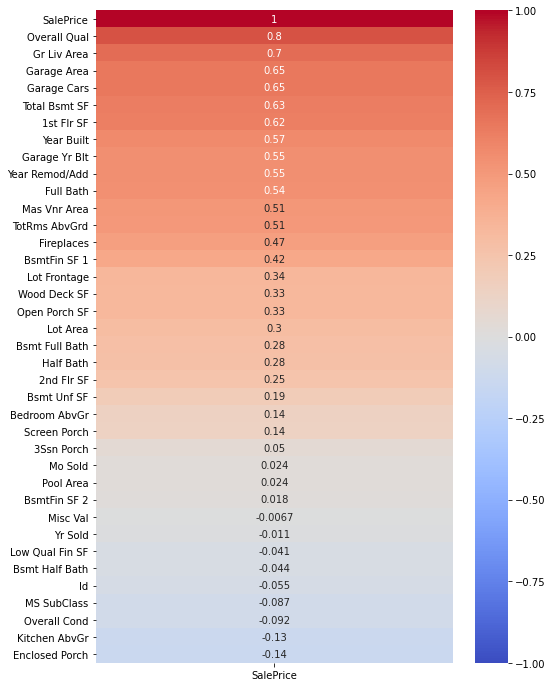

In [24]:
plt.figure(figsize=(8, 12))
sns.heatmap(df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
            cmap='coolwarm',
            vmin=-1,
            annot=True);

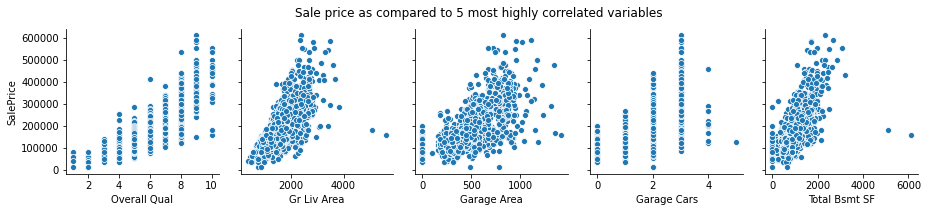

In [25]:
g = sns.pairplot(df,
                 x_vars=['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF'],
                 y_vars=['SalePrice'])
g.fig.suptitle('Sale price as compared to 5 most highly correlated variables', y = 1.1);

Let's blow up the `Gr Liv Area` plot, as it looks like it may contain some outliers...

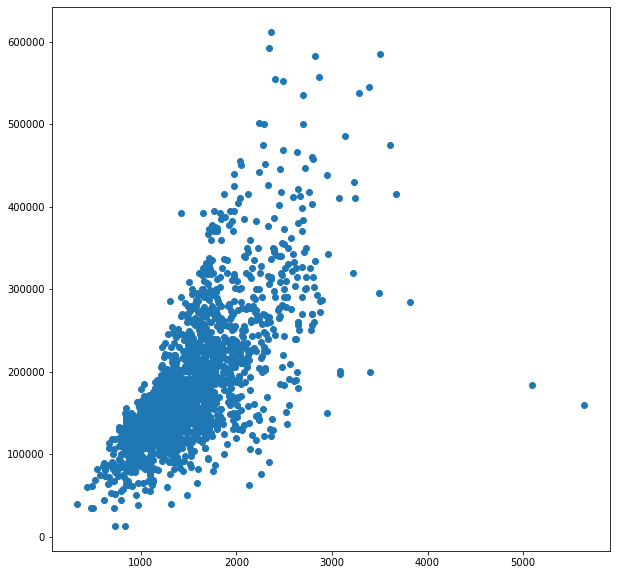

In [26]:
plt.figure(figsize=(10, 10))
plt.scatter(df['Gr Liv Area'], df['SalePrice']);

Why are the two 5000+ square feet homes selling for so little?

In [27]:
is_huge = df['Gr Liv Area'] >= 5000
df.loc[is_huge, :]

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,60,RL,313,63887,Pave,NA,IR3,Bnk,AllPub,...,0,480,Gd,NA,NA,0,1,2008,New,160000
1885,2181,20,RL,128,39290,Pave,NA,IR1,Bnk,AllPub,...,0,0,NA,NA,Elev,17000,10,2007,New,183850


I frankly can't explain why these two homes are selling for so little, so I'm going to assume they're errors and remove them.

In [28]:
df.drop(index=df.loc[is_huge, :].index, inplace=True)

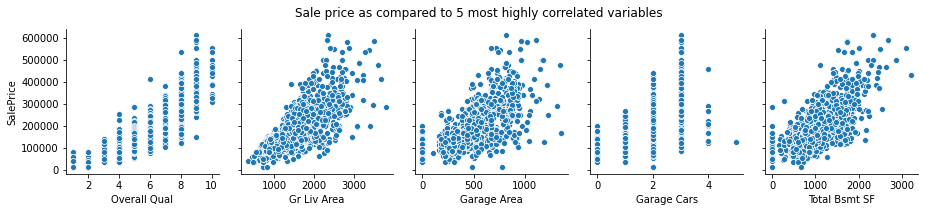

In [29]:
g = sns.pairplot(df,
                 x_vars=['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF'],
                 y_vars=['SalePrice'])
g.fig.suptitle('Sale price as compared to 5 most highly correlated variables', y = 1.1);

# Exporting clean data

In [30]:
filepath = 'datasets/train_clean.csv'
df.to_csv(filepath, index=False)

filepath = 'datasets/test_clean.csv'
test_df.to_csv(filepath, index=False)